# Chapter5: Financial Labels


The present notebook is an implimentation of 5th chapter of __Marcos López de Prado__'s book named:
__Machine Learning for Asset Managers__
This notebook is also a part of a presentation from __Ali Abedi__ and __Ehsan Tabatabaei__ on the same chapter.
In the following cells we will see codes on:

* [1 Fixed-horizon labeling method](#section1)
    * [1.2 Returns standardization for fixed-horizon method](#section2)
    * [1.3 Comparison between raw and standardized returns](#section3)
* [2 Triple-barrier labeling method](#section4)
* [3 Trend-scanning labeling method](#section5)
* [4 References](#section6)

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm1
import numpy as np
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')

In [2]:
# %matplotlib notebook
%matplotlib inline

<a id='section1'></a>
## 1. Fixed Horizen Labeling

In this method, we define a fixed threshold and see if today's return exceeds the threshold or not.
Today's label is defined using:

$y_i = \left\{\begin{array}{c}
    -1 \text { if } r_{t_{i, 0}, t_{i, 1}}<-\tau, \\
    0 \text { if }\left|r_{i_{i, 0}, t_{i, 1}}\right| \leq \tau, \\
    1 \text { if } r_{t_{i, 0}, t_{i, 1}}>\tau,
    \end{array}\right. $

In [3]:
Stock = yf.Ticker("AAPL")
StockHist = Stock.history(period='6d',interval='1m')

In [4]:
StockHist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2020-06-26 09:30:00-04:00,364.41,364.98,363.85,364.96,834026,0,0
2020-06-26 09:31:00-04:00,364.92,365.32,364.31,364.33,186382,0,0
2020-06-26 09:32:00-04:00,364.36,364.39,363.37,363.53,158219,0,0
2020-06-26 09:33:00-04:00,363.52,364.45,363.40,364.11,173888,0,0
2020-06-26 09:34:00-04:00,364.15,364.16,363.53,363.75,89643,0,0


In [5]:
FixedHorizen = 20 # bar
StockHist = StockHist.assign(dReturnH=round(100*(StockHist.Close.shift(-FixedHorizen)/StockHist.Close-1),1))
StockHist = StockHist.assign(dReturnH=round(100*(StockHist.Close.shift(-FixedHorizen)/StockHist.Close-1),1))
ThresholdP = StockHist.dReturnH.describe()['mean']+1.5*StockHist.dReturnH.describe()['std']
ThresholdN = StockHist.dReturnH.describe()['mean']-1.5*StockHist.dReturnH.describe()['std']

StockHist = StockHist.assign(colorFH='#e8eb44')
StockHist.loc[StockHist.dReturnH<ThresholdN,'colorFH'] = '#de003b'
StockHist.loc[StockHist.dReturnH>ThresholdP,'colorFH'] = '#009157'



In [6]:
# Adding Dynamic Volatility
stdPast1Hour =  [np.std(StockHist.dReturnH.values[I-60:I]) for I in range(len(StockHist))]
muPast1Hour  =   [np.mean(StockHist.dReturnH.values[I-60:I]) for I in range(len(StockHist))]
StockHist = StockHist.assign(dReturnHSTD = 
                             [(StockHist.dReturnH.values[I]-muPast1Hour[I])/stdPast1Hour[I]
                                                          for I in range(0,len(StockHist))])
ThresholdP = 1.5 # because of Standardization 
ThresholdN = -1.5

StockHist = StockHist.assign(colorFHSTD='#e8eb44')
StockHist.loc[StockHist.dReturnHSTD<ThresholdN,'colorFHSTD'] = '#de003b'
StockHist.loc[StockHist.dReturnHSTD>ThresholdP,'colorFHSTD'] = '#009157'

Text(0, 0.5, 'Return (%)')

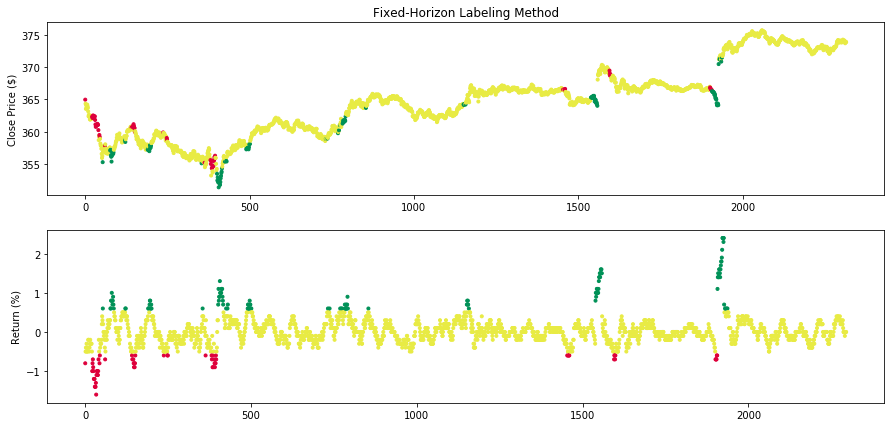

In [7]:
plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.scatter(range(len(StockHist.index)),StockHist.Close,c=StockHist.colorFH,marker='.')
plt.title('Fixed-Horizon Labeling Method')
plt.ylabel('Close Price ($)')

plt.subplot(2,1,2)
plt.scatter(range(len(StockHist.index)),StockHist.dReturnH,c=StockHist.colorFH,marker='.')

plt.ylabel('Return (%)')


# plt.savefig("FixedHorizonRawReturn.svg")

<a id='section2'></a>
## 1.2 Returns standardization for fixed-horizon method

As de Prado suggests, heteroscedasticity of financial data makes it difficult to take a fixed threshold. So, instead we define the labels on the standardized returns:

$z_{t_{i,0},t_{i,1}} = \frac{r_{t_{i,0},t_{i,1}} - \mu}{\sigma}$

$y_i = \left\{\begin{array}{c}
    -1 \text { if } z_{t_{i, 0}, t_{i, 1}}<-\tau, \\
    0 \text { if }\left|z_{i_{i, 0}, t_{i, 1}}\right| \leq \tau, \\
    1 \text { if } z_{t_{i, 0}, t_{i, 1}}>\tau,
    \end{array}\right. $

Text(0, 0.5, 'Standardized Returns (%)')

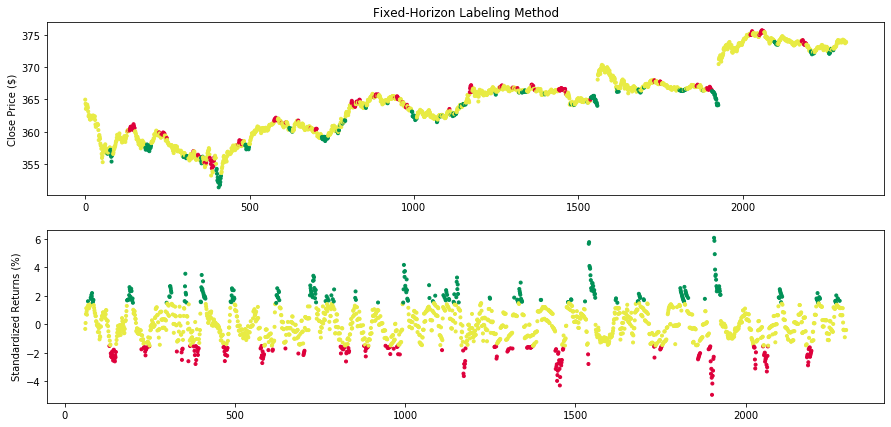

In [8]:
plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.scatter(range(len(StockHist.index)),StockHist.Close,c=StockHist.colorFHSTD,marker='.')
plt.title('Fixed-Horizon Labeling Method')
plt.ylabel('Close Price ($)')

plt.subplot(2,1,2)
plt.scatter(range(len(StockHist.index)),StockHist.dReturnHSTD,c=StockHist.colorFHSTD,marker='.')
plt.ylabel('Standardized Returns (%)')

# plt.savefig("FixedHorizonStandardizedReturn.svg")

<a id='section3'></a>
## 1.2 Comparison between raw and standard returns

Text(0.5, 1.0, 'Labeling based on standardized Return')

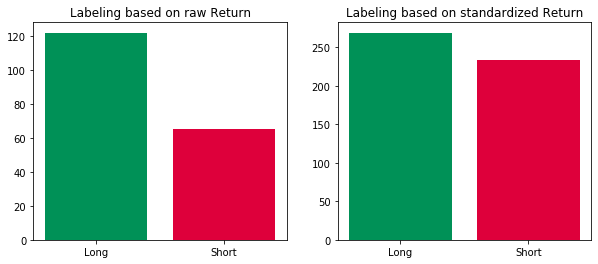

In [9]:
unique, counts = np.unique(StockHist.colorFH, return_counts=True)
uniqueSTD, countsSTD = np.unique(StockHist.colorFHSTD, return_counts=True)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
unique[:-1] = ['Long','Short']
plt.bar(unique[:-1], counts[:-1],color = ['#009157','#de003b'])
plt.title('Labeling based on raw Return')

plt.subplot(1,2,2)
uniqueSTD[:-1] = ['Long','Short']
plt.bar(unique[:-1], countsSTD[:-1],color = ['#009157','#de003b'])
plt.title('Labeling based on standardized Return')

# plt.savefig('Fixed Horizon Labeling Heteroscedasticity Problem.svg')

<a id='section4'></a>
# Triple-Barrier Labeling

In this labeling method, we simulize a real investor's reactions. 
Holding a positioncan end to one of the below:

* profit target is achieved,
* stop loss limit is reached,
* the position is closed after certain bars.

In [10]:
# Choosing another TimeFrame to have better visualization
Stock2 = yf.Ticker("AAPL")
StockHist2 = Stock2.history(period='3y',interval='1d')

In [11]:
def get_touch(data, Index, TimeBarrier):
    returns = [100*(data.Close.shift(-TimeB)/data.Close-1)[Index] for TimeB in range(1,TimeBarrier+1)]
    maxReturn, maxReturnIndex =  max(returns), returns.index(max(returns))
    minReturn, minReturnIndex =  min(returns), returns.index(min(returns))
    return minReturn,maxReturn

In [12]:
TimeBarrier = 20
StockHist2 = StockHist2.assign(dReturnH=round(100*(StockHist2.Close.shift(-FixedHorizen)/StockHist2.Close-1),1))
ThresholdP = StockHist2.dReturnH.describe()['mean']+1*StockHist2.dReturnH.describe()['std']
ThresholdN = StockHist2.dReturnH.describe()['mean']-1*StockHist2.dReturnH.describe()['std']
StockHist2 = StockHist2.assign(colorTB='#e8eb44')

for Index in StockHist2.index:
    
    minReturn,maxReturn = get_touch(StockHist2,Index,TimeBarrier)

    if minReturn < ThresholdN:
        StockHist2.loc[Index,'colorTB'] = '#de003b'

    elif maxReturn > ThresholdP:
        StockHist2.loc[Index,'colorTB'] = '#009157'


Text(0, 0.5, 'Return (%)')

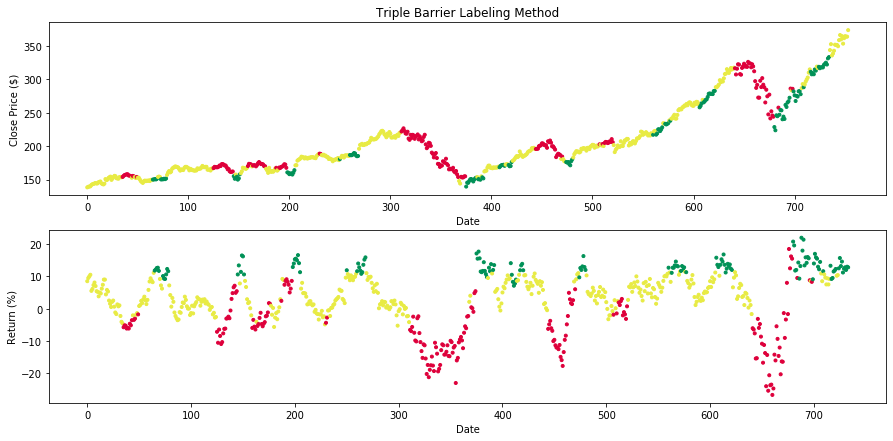

In [13]:
plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.scatter(range(len(StockHist2.index)),StockHist2.Close,c=StockHist2.colorTB,marker='.')

plt.title('Triple Barrier Labeling Method')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

plt.subplot(2,1,2)
plt.scatter(range(len(StockHist2.index)),StockHist2.dReturnH,c=StockHist2.colorTB,marker='.')

plt.xlabel('Date')
plt.ylabel('Return (%)')

# plt.savefig("TripleBarrier.svg")

<a id='section5'></a>
# Trend-Scanning Method

Because triple-barrier method has got many parameters, de Prado suggests another method which incorporates the current trend slope. The trend is calculated using the following regression:
$$
x_{t+l}=\beta_{0}+\beta_{1} l+\varepsilon_{t+l},
$$

$$
\hat{t}_{\hat{\beta}_{1}} = \frac{\hat{\beta}_{1}}{\hat{\sigma}_{\hat{\beta_{1}}}},
$$

Note that the maximum number of $l$ is defined such that $\hat{t}_{\hat{\beta}_{1}}$ is maximized.

In [14]:
from tqdm import tqdm

In [15]:
def get_tvalueIndex(data, StartIndex, ForwardHorizon):
    tvalues = []
    
    for I in range(StartIndex+5,StartIndex+ForwardHorizon):
        
        close =data.Close[StartIndex:I]
        x=np.ones((close.shape[0],2))
        x[:,1]=np.arange(close.shape[0])
        ols=sm1.OLS(close,x).fit()
     
        tvalues.append(round(ols.tvalues[1],1))
        
    maxTvalue = max(tvalues, key=abs,)
    return  maxTvalue


In [16]:
StockHist2 = StockHist2.assign(colorValueTrend=0)
ForwardHorizon = 50
for I in tqdm(range(0,len(StockHist2)-ForwardHorizon)):
    StockHist2.loc[StockHist2.index[I],'colorValueTrend'] = get_tvalueIndex(StockHist2,I,ForwardHorizon)

100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:33<00:00, 21.29it/s]


Text(0, 0.5, 'Return (%)')

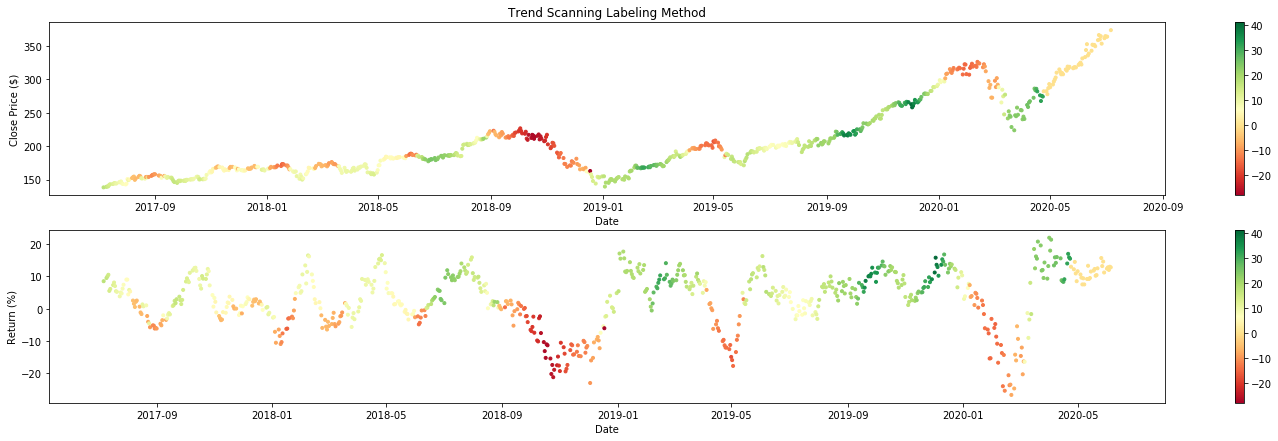

In [17]:
plt.figure(figsize=(25,7))
plt.subplot(2,1,1)

scClose = plt.scatter(StockHist2.index,StockHist2.Close,   c=(StockHist2.colorValueTrend),
                 marker='.',cmap='RdYlGn',alpha=1)
plt.colorbar(scClose)

plt.title('Trend Scanning Labeling Method')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

plt.subplot(2,1,2)
scReturn = plt.scatter(StockHist2.index,StockHist2.dReturnH,c=(StockHist2.colorValueTrend),
                 marker='.',cmap='RdYlGn')
plt.colorbar(scReturn)
plt.xlabel('Date')
plt.ylabel('Return (%)')

# plt.savefig("TrendScanningMethod.svg")

<a id='section6'></a>
# References

The presentation and this Jupyter notebook are conducted by:

* <a ref="https://www.linkedin.com/in/alidotab/">Ali Abedi</a> (aliabedi8044@gmail.com)
* <a ref="https://www.linkedin.com/in/ehsan-tabatabaei-71617866/">Ehsan Tabatabaei</a> (ehsan.taba94@gmail.com)

This notebook is in-fact a code implementation of $5^{th}$ chapter of this book:

<a ref="https://www.cambridge.org/core/books/machine-learning-for-asset-managers/6D9211305EA2E425D33A9F38D0AE3545">Machine Learning for Asset Managers</a>

by <a ref="https://scholar.google.com/citations?user=5JB7RscAAAAJ">Marcos López de Prado</a>